In [1]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt
from cmcrameri import cm as cmc

from utils import integrated_zonal_momentum_terms, load_config, default_params, axes_styling, calculate_bathymetry

In [2]:
config = "slope-001"

ds = xr.open_dataset("../output/"+config+".nc").squeeze()
params = load_config("../configs/"+config+".json", default_params)

In [3]:
xidx = 45
terms = integrated_zonal_momentum_terms(params, ds, xidx)
terms= terms.drop("massflux")

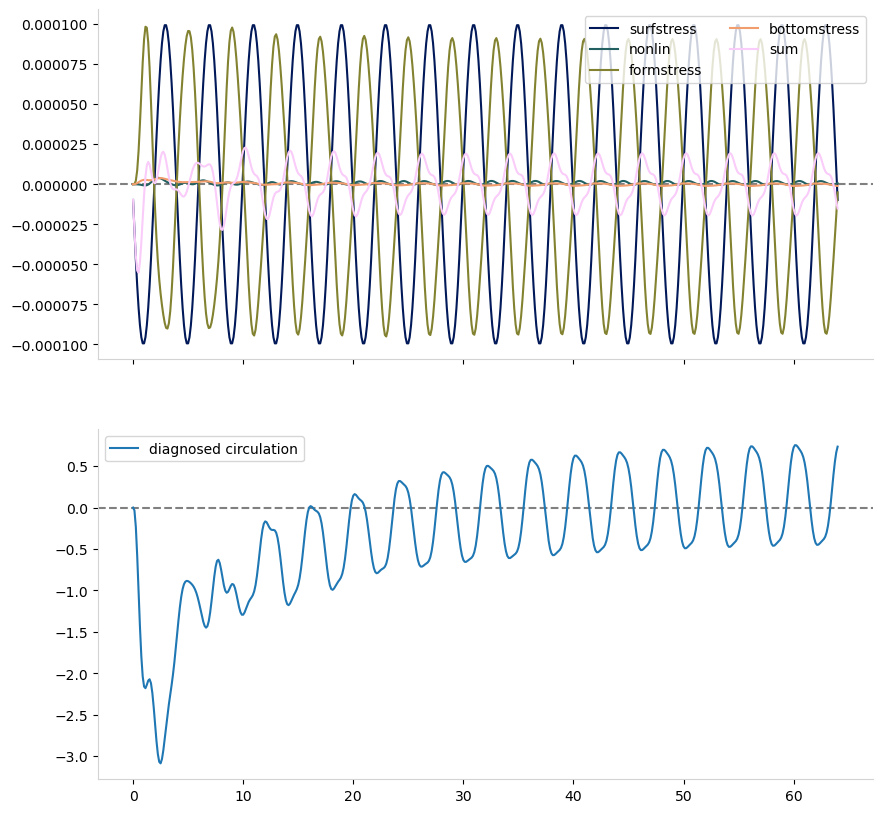

In [4]:
fig, [ax, ax2] = plt.subplots(figsize=(10,10), nrows=2, sharex=True)
axes_styling(ax)
axes_styling(ax2)
ax.axhline(0, color="gray", ls="--")
ax2.axhline(0, color="gray", ls="--")

terms["sum"] = terms["surfstress"] + terms["nonlin"] + terms["formstress"] + terms["bottomstress"]

tday = terms.time / np.timedelta64(1,"D")

colors = cmc.batlow(np.linspace(0, 1, len(terms)))
for term, color in zip(terms, colors):
    ax.plot(tday, -terms[term], label=term, color=color)
    
circ_est = (terms["sum"]*params["outputtime"]).cumsum("time")
circ_diag = (ds.v.isel(xC=xidx)*calculate_bathymetry(ds.xC.isel(xC=xidx), ds.yF, params)).mean("yF")


#ax2.plot(tday, -circ_est, label = "estimated circulation")
ax2.plot(tday, -circ_diag, label = "diagnosed circulation")

    
ax.legend(ncols=2)
ax2.legend()

#ax2.set_xlim(50,60)
fig.savefig(f"../figures/terms/xcontour/xcontour_terms_ts_{config}.png")

In [5]:
idxs = np.arange(15, 75)
termlist = []
circlist = []
for xidx in idxs:
    terms = integrated_zonal_momentum_terms(params, ds, xidx)
    terms= terms.drop("massflux")
    
    circ = -(ds.v.isel(xC=xidx)*calculate_bathymetry(ds.xC.isel(xC=xidx), ds.yF, params)).mean("yF")
    
    termlist.append(terms)
    circlist.append(circ)
    
    
results = xr.concat(termlist, dim="x")
results["sum"] = results["surfstress"] + results["nonlin"] + results["formstress"] + results["bottomstress"]
circ = xr.concat(circlist, dim="x")

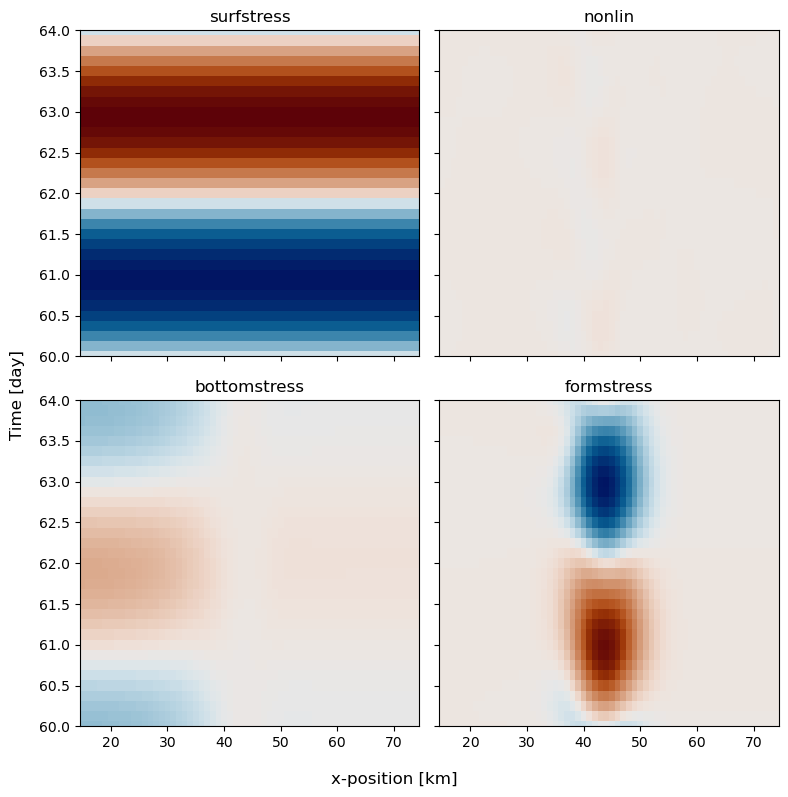

In [6]:
fig, axes = plt.subplots(figsize=(8,8), ncols=2, nrows=2, sharex=True, sharey=True)

vmax = np.max([np.abs(results[term]).quantile(0.98) for term in results])

terms = ["surfstress", "nonlin", "bottomstress", "formstress"]
for term, ax in zip(terms, axes.flatten()):
    ax.pcolormesh(idxs, tday, -results[term].T, vmin=-vmax, vmax=vmax, cmap=cmc.vik)
    ax.set_title(term)
    
fig.supxlabel("x-position [km]")
fig.supylabel("Time [day]")
    
Td = params["T"] / (24*60*60)   
tmaxd = params["tmax"] / (24*60*60)  

ax.set_ylim(tmaxd-Td, tmaxd)
#ax.set_xlim(15, 75)
fig.tight_layout()

fig.savefig(f"../figures/terms/xcontour/xcontour_terms_cm_{config}.png")

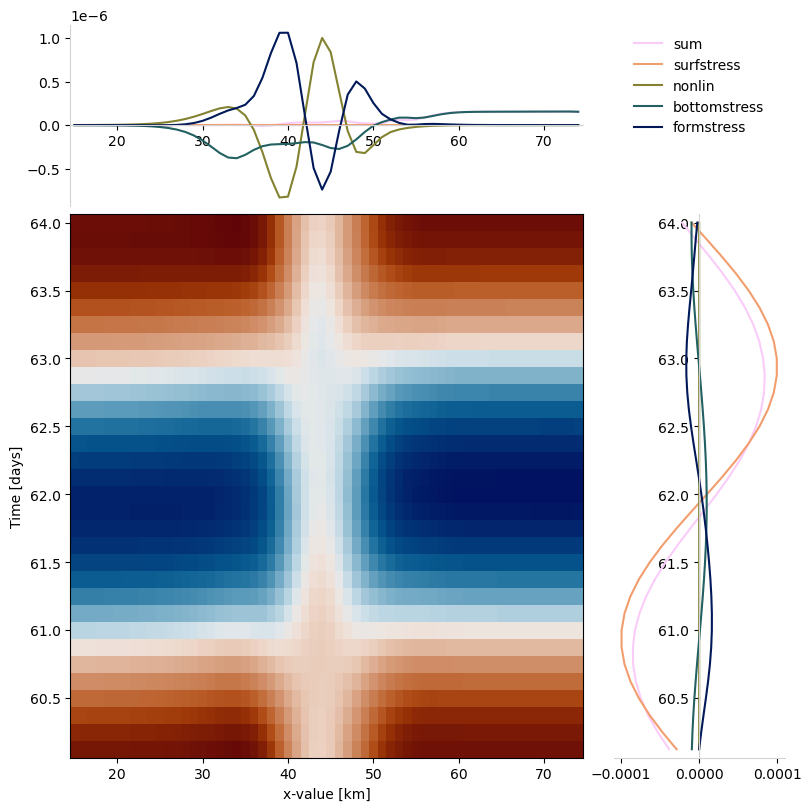

In [7]:
axd = plt.figure(layout="constrained", figsize=(8,8)).subplot_mosaic(
    [
        ["tmean", "legend"],
        ["circ", "xmean"],
    ],
    #empty_sentinel="BLANK",
    # set the height ratios between the rowsslice(int(tmax-T), int(tmax))
    height_ratios=[1, 3],
    # set the width ratios between the columns
    width_ratios=[3, 1],
)

cmap = cmc.batlow
n = 5
colors = [cmap(1 - i / (n - 1)) for i in range(n)]

axd["tmean"].sharex(axd["circ"])
axd["xmean"].sharey(axd["circ"])

axd["tmean"].spines['right'].set_color('none')  # Remove the right spine
axd["tmean"].spines['top'].set_color('none')  # Remove the top spine
axd["tmean"].spines['bottom'].set_position('zero')  # Set the bottom spine position
axd["tmean"].spines['left'].set_color('lightgray')
axd["tmean"].spines['bottom'].set_color('lightgray')

axd["xmean"].spines['right'].set_color('none')  # Remove the right spine
axd["xmean"].spines['top'].set_color('none')  # Remove the top spine
axd["xmean"].spines['left'].set_position('zero')  # Set the bottom spine position
axd["xmean"].spines['left'].set_color('lightgray')
axd["xmean"].spines['bottom'].set_color('lightgray')

Tn = int(params["T"]/params["outputtime"])

circT = circ.isel(time=slice(-Tn, None))
resultsT = results.isel(time=slice(-Tn, None))
vmax = np.max(np.abs(circT))
axd["circ"].pcolormesh(idxs, tday[-Tn:], circT.T, 
                  vmin=-vmax, vmax=vmax, 
                  cmap=cmc.vik)

axd["circ"].set_xlabel("x-value [km]")
axd["circ"].set_ylabel("Time [days]")

terms = ["sum", "surfstress", "nonlin", "bottomstress", "formstress"]
for term, color in zip(terms, colors):
    result = -resultsT[term]
    tmean = result.mean("time")
    xmean = result.mean("x")
    
    axd["xmean"].plot(xmean, tday[-Tn:], label=term, color=color)
    axd["tmean"].plot(idxs, tmean, label=term, color=color)
    
    axd["legend"].plot([None, None], [None, None], label=term,color=color)
    
axd["legend"].axis("off")
axd["legend"].legend(loc='upper center', 
                    frameon=False,
                )

fig.savefig(f"../figures/terms/xcontour/xcontour_terms_integrated_{config}.png")